# 1. Data Analyse of simulation runs

### Some general information
To start in my simulation I take 360 steps of simpy environment as 1 hour, a day consists of 8 hours which are linked to the schedules of the students.

I take the assumption that the simulation only simulates the hours the students are in school, so they have no need to go home.

The data gathered consists of a few columns `[Timestamp, Name, Action, Duration]`. I'd like to clarify some things about the `Action` column, the entries constists of `Co`, `Ha` and `Cl` these corresponds to the possible states for the student.

## 1. Baseline

Before making the project complexer I wanted to gather a baseline of data. So i created a data storage class where I monitor how much time a student has spend in a certain state. With this class I ran the simulation without altering any core functionality yet. This way we have some information whether the solutions I provide actually improve the gathering of coffee.

In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

batch_dir = lambda batch: os.path.join("batches", batch)

base_df = pd.read_csv(os.path.join("..", batch_dir("batch_base"), "runs0", "data.csv"), index_col=False)

base_df.head(10)

,ID,Timestamp,Name,Action,Duration,Day,Hour,Total Drinks,Time In Class
0,0,5,D,Co,4,0,0,0,0.0
1,1,7,O,Co,6,0,0,1,0.0
2,2,9,Q,Co,8,0,0,0,0.0
3,3,13,A,Co,10,0,0,0,0.0
4,4,15,V,Co,13,0,0,2,0.0
5,5,21,Y,Co,18,0,0,2,0.0
6,6,21,X,Co,18,0,0,1,0.0
7,7,25,C,Co,21,0,0,0,0.0
8,8,35,],Co,32,0,0,5,0.0
9,9,37,I,Co,33,0,0,4,0.0


In [42]:
def plot_data(data_frame: pd.DataFrame):
    sorted_data = data_frame[data_frame["Action"] == "Co"]
    unique, counts = np.unique(sorted_data["Duration"], return_counts=True)

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), dpi=100)
    fig.tight_layout(pad=3)

    ax[0].bar(unique, counts)
    ax[0].set_title("Display of time spent in coffee queue")
    ax[0].set_xlabel("Time spend in coffee queue")
    ax[0].set_ylabel("Amount of times this time occured")

    avg_time_spent = sorted_data.groupby(["Day", "Name"])["Time In Class"].max().groupby("Day").mean()
    ax[1].plot(np.arange(len(avg_time_spent)), avg_time_spent)
    ax[1].set_xlabel("Days the simulation ran")
    ax[1].set_ylabel("Average time spent in class (per student)")

    # sum_total_drinks = sorted_data.groupby(["Day", "Name"])["Total Drinks"].sum().groupby("Day").mean()
    avg_total_drinks = sorted_data.groupby(["Day", "Name"])["Total Drinks"].max().groupby("Day").mean()

    # ax[2].plot(np.arange(len(sum_total_drinks)), sum_total_drinks)
    # ax[2].set_xlabel("Days the simulation ran")
    # ax[2].set_ylabel("Average total drink combined")

    ax[2].plot(np.arange(len(avg_total_drinks)), avg_total_drinks)
    ax[2].set_xlabel("Days the simulation ran")
    ax[2].set_ylabel("Average total drinks per student")
    plt.show()
    return sorted_data, avg_total_drinks, avg_time_spent

def plot_comparison(data_frame_new: pd.DataFrame, data_frame_old: pd.DataFrame):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 9), dpi=100)
    fig.tight_layout()
    
    unique_durations, counts_durations = np.unique(data_frame_new["Duration"], return_counts=True)

    ax[0].bar(unique_durations, counts_durations, color="green", label="New")

    unique_durations, counts_durations = np.unique(data_frame_old["Duration"], return_counts=True)
    ax[0].bar(unique_durations, counts_durations, color="red", label="Base")
    ax[0].legend()

    avg_total_drinks = data_frame_new.groupby(["Day", "Name"])["Total Drinks"].max().groupby("Day").mean()

    ax[1].plot(np.arange(len(avg_total_drinks)), avg_total_drinks, color="green", label="New")
    ax[1].set_xlabel("Days the simulation ran")
    ax[1].set_ylabel("average drinks that day")

    avg_total_drinks = data_frame_old.groupby(["Day", "Name"])["Total Drinks"].max().groupby("Day").mean()

    ax[1].plot(np.arange(len(avg_total_drinks)), avg_total_drinks, color="red", label="Base")

    avg_time_spent = data_frame_new.groupby(["Day", "Name"])["Time In Class"].max().groupby("Day").mean()
    ax[2].plot(np.arange(len(avg_time_spent)), avg_time_spent, color="green", label="new")
    ax[2].set_xlabel("Days the simulation ran")
    ax[2].set_ylabel("average time in class that day")

    avg_time_spent = data_frame_old.groupby(["Day", "Name"])["Time In Class"].max().groupby("Day").mean()
    ax[2].plot(np.arange(len(avg_time_spent)), avg_time_spent, color="red", label="Base")



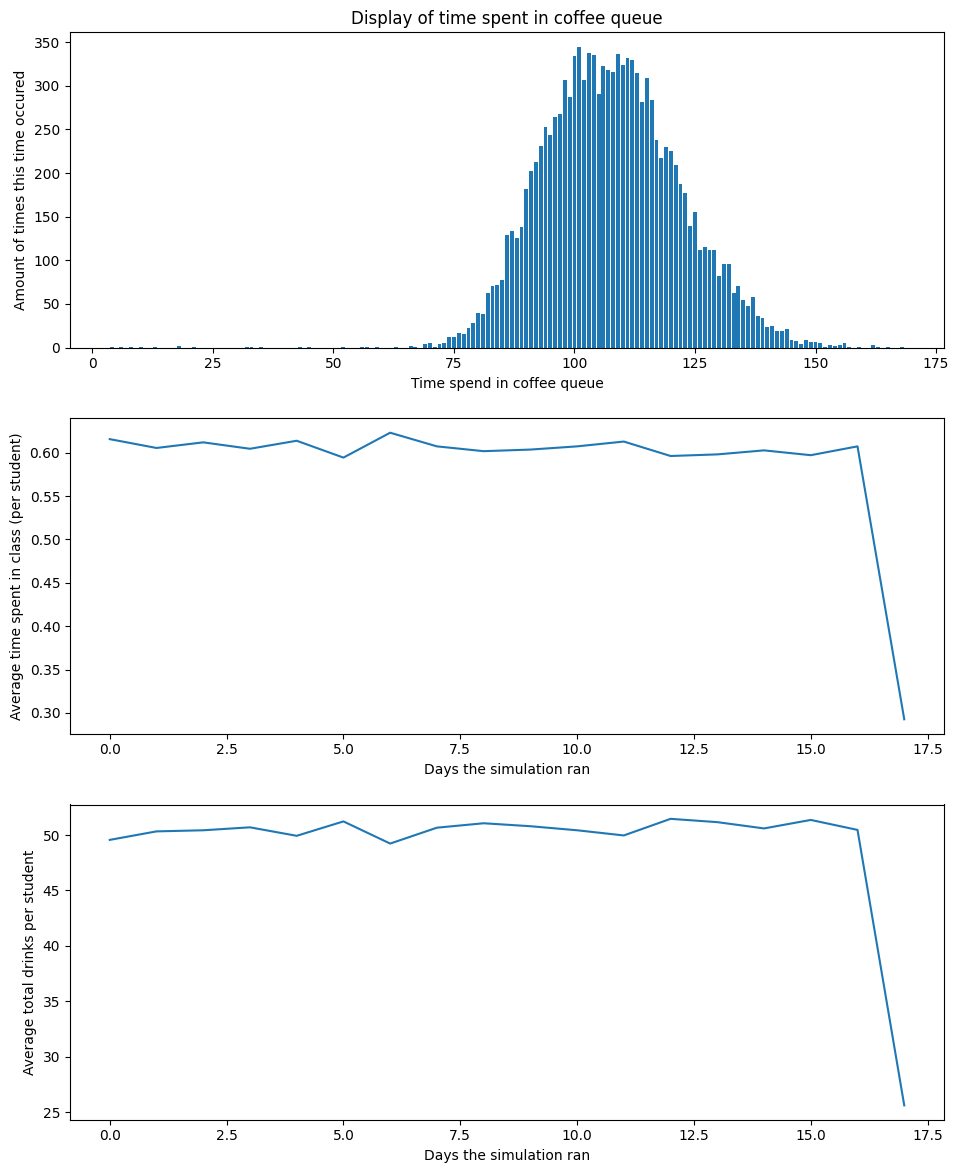

In [43]:
base_sorted_df, base_avg_total_drinks, base_avg_time_in_class = plot_data(base_df)

In [44]:

np.round(base_sorted_df["Duration"].mean()), np.round(base_avg_total_drinks.mean()), np.round(base_avg_time_in_class.mean(), 2)



(108.0, 49.0, 0.59)

In the plots above is visible how much time the students spent inside the `coffee_state`, taking into account that all they do in the coffee state is wait in line and get coffee the plots indicate how much time was spent inside of the coffee queue. They spent an average of 108 time steps inside of the queue, which in our simulation indicates a little over 15 minutes. 

Also the two line plots indicate how much drinks were collected over the days and also the average. The average of the most bottom line (Average drinks per student per day) is `49`.

The last data point that is important for our baseline is the time spent in class, we take the average time spent in class per student. The unit it is displayed in is average hours per student per day. For our baseline this is `0.59`, indicating a little over half an hour

Taking the `15 minutes` or `108 timesteps`, the `49 average drinks per student per day` and the `0.59 hours average spent in class per studetn per day` as baseline in my project, it's time to move on. In my opinion there is two ways to move onwards from this point, one would be to create more states to simulate realism, such as a `wandering_state` as students dont spend all their time moving from class through the hallway to the coffee machine. Or we could introduce a `break_state` indicating that students need to be on a break before being able to get coffee.

## 2. Characteristics

Another way would be to introduce characteristics for students, which is the route i started with. In the base simulation the students always enter the queue no matter how long this queue is, which seems unlogical to me. 

A student will have a `waiting_patience`, this indicates length of the queue a student can tolerate before deciding to come back later

In [45]:
char_df = pd.read_csv(os.path.join("..", batch_dir("batch_char"), "runs0", "data.csv"), index_col=False)

char_df.head(10)

,ID,Timestamp,Name,Action,Duration,Day,Hour,Total Drinks,Time In Class
0,0,1,N,Co,0,0,0,0,0.0
1,1,5,I,Co,4,0,0,0,0.0
2,2,5,P,Co,4,0,0,0,0.0
3,3,5,\,Co,4,0,0,0,0.0
4,4,5,L,Co,2,0,0,0,0.0
5,5,5,V,Co,2,0,0,0,0.0
6,6,5,U,Co,1,0,0,0,0.0
7,7,9,X,Co,4,0,0,0,0.0
8,8,9,J,Co,3,0,0,0,0.0
9,9,9,O,Co,3,0,0,0,0.0


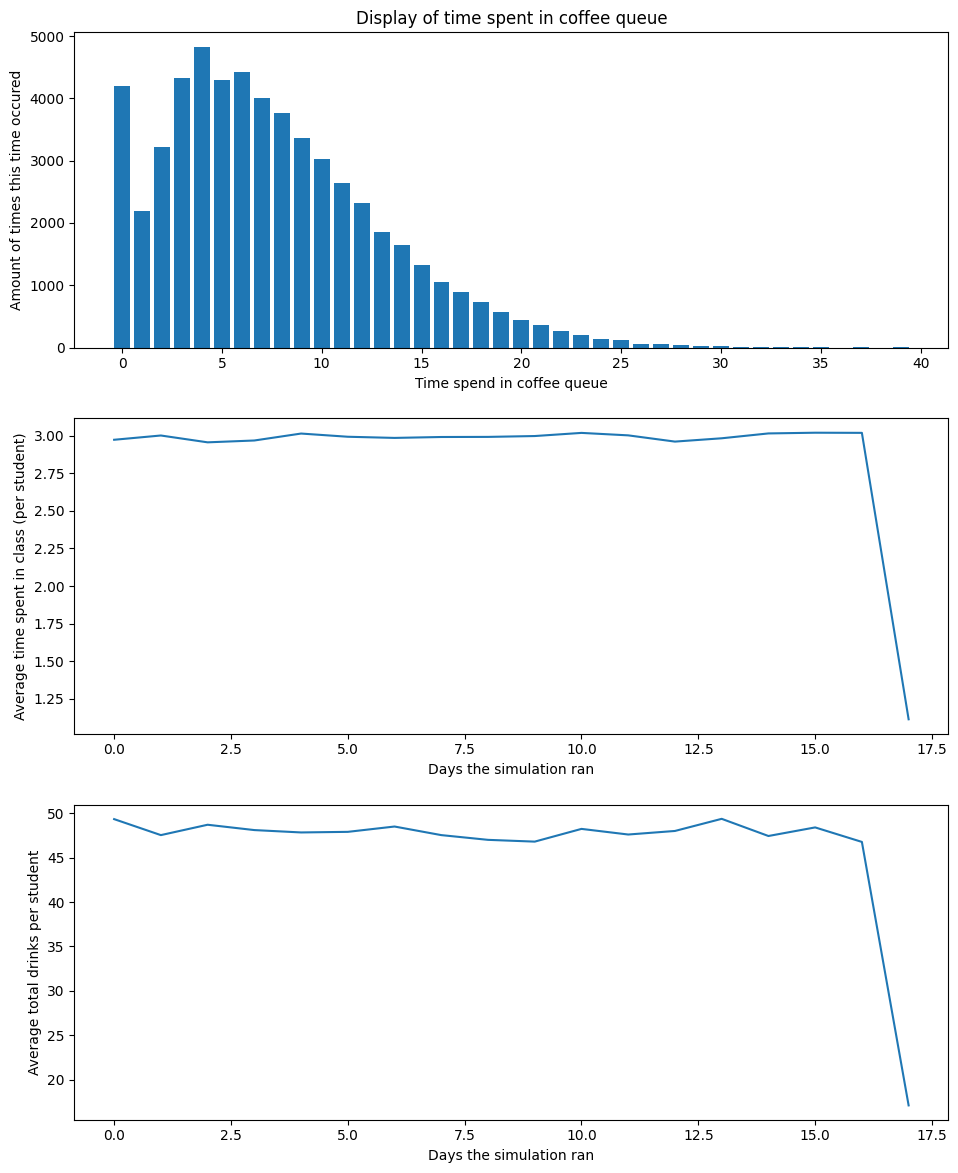

In [46]:
char_sorted_df, char_avg_total_drinks, char_avg_time_in_class = plot_data(char_df)

In [47]:
np.round(char_sorted_df["Duration"].mean()), np.round(char_avg_total_drinks.mean()), np.round(char_avg_time_in_class.mean(), 2)

(8.0, 46.0, 2.89)

We can definitely visibly see a shift in the amount of time spend inside a queue for coffee. But lets plot a few of the key differences

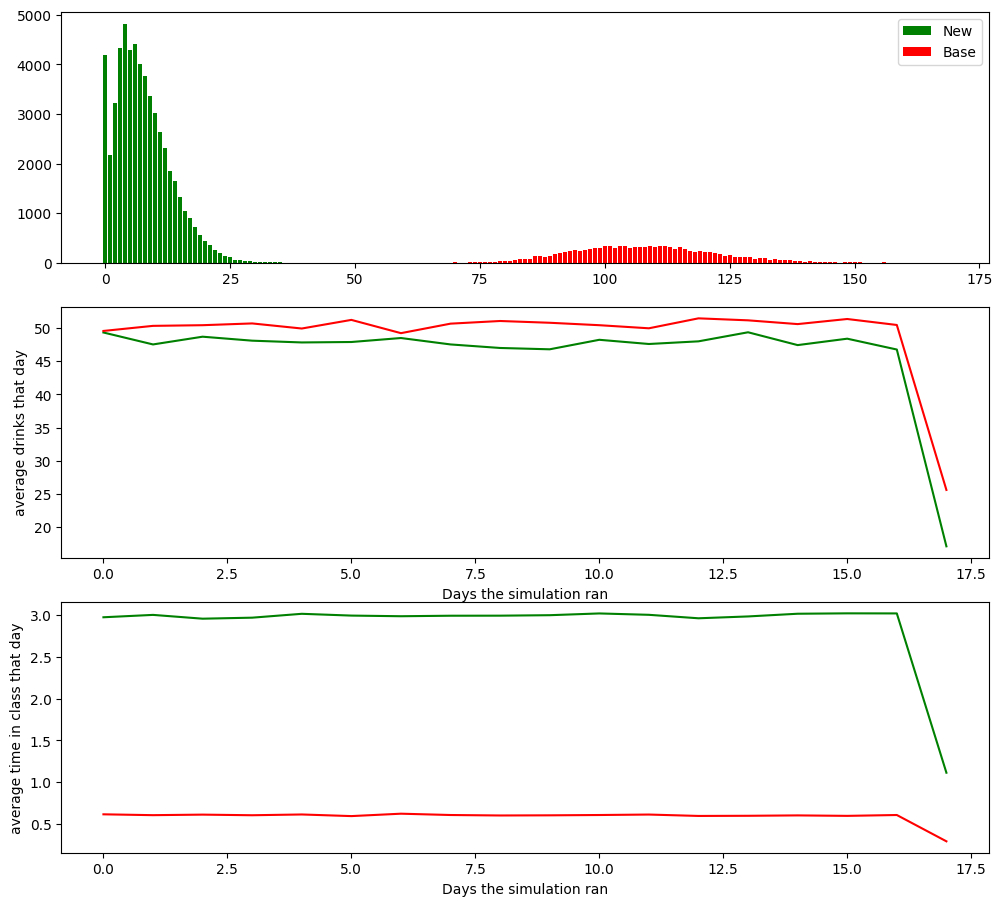

In [48]:
plot_comparison(char_sorted_df, base_sorted_df)


From the plots it's visible that with the added implementation where students decide to try another time reduces the time spent inside the coffee queue drastically, while the average drinks per day only decreased by a little amount. Which means that by just introducing something simple like a `waiting_patience` variable we can increase the performance of coffee gathering.

Now lets move on to the next step which will be scheduling. Students at school have a certain schedule, when to be in class and when to go on break. Let's now force students to be in a classroom when their schedule tells them to.

## 3. Scheduling

For this part a little clarification is needed. A schedule consists of 8 numbers in an array. Each number is either a 0 or 1. The 0 indicates a break and the 1 indicates a lesson. The base schedule will be: `[1,1,0,1,0,0,1,1]`. So that will be two hours of lessons, 1 hour break, 1 hour lesson, 2 hour break and lastly 2 hour lessons. Schedules are decided based on the class a student is in. 

In the `Scheduler` class the parameter `classes` decides how many classes will be made. For each class the schedule will move each element to the right. Which results to the following: 

- Class Index 0: `[1,1,0,1,0,0,1,1]`
- Class Index 1: `[1,1,1,0,1,0,0,1]`
- etc

In [49]:
sched_df = pd.read_csv(os.path.join("..", batch_dir("batch_sched"), "runs0", "data.csv"), index_col=False)

sched_df.head(10)

,ID,Timestamp,Name,Action,Duration,Day,Hour,Total Drinks,Time In Class
0,0,2,A,Co,0,0,0,0,0.0
1,1,3,A,Co,0,0,0,0,0.0
2,2,4,E,Co,0,0,0,0,0.0
3,3,5,D,Co,0,0,0,0,0.0
4,4,9,E,Co,4,0,0,0,0.0
5,5,9,Z,Co,3,0,0,0,0.0
6,6,9,G,Co,1,0,0,0,0.0
7,7,11,E,Co,0,0,0,0,0.0
8,8,15,L,Co,14,0,0,5,0.0
9,9,15,A,Co,10,0,0,0,0.0


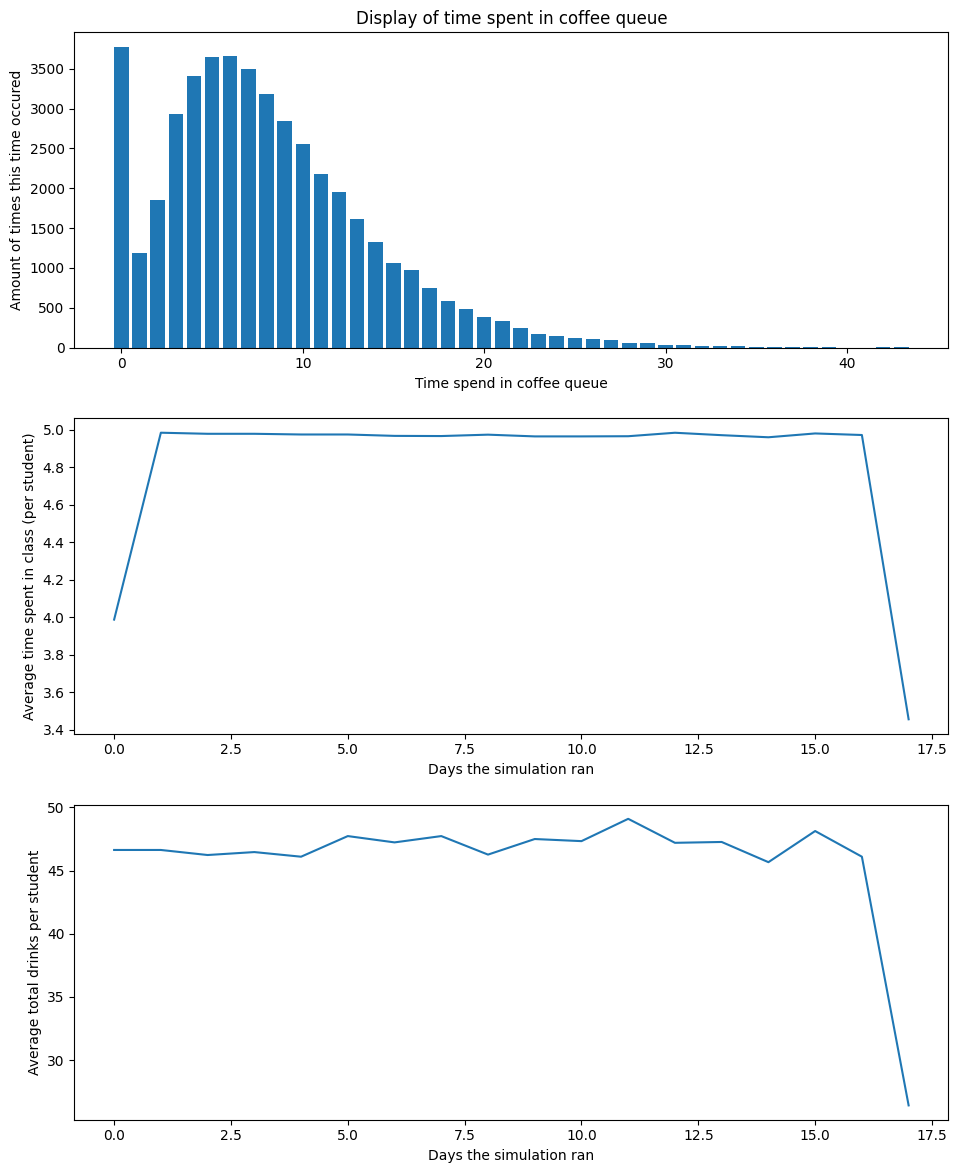

In [ ]:

sched_sorted_df, sched_avg_total_drinks, sched_avg_time_in_class = plot_data(sched_df)

In [51]:
np.round(sched_sorted_df["Duration"].mean()), np.round(sched_avg_total_drinks.mean()), np.round(sched_avg_time_in_class.mean(), 2)

(8.0, 46.0, 4.83)

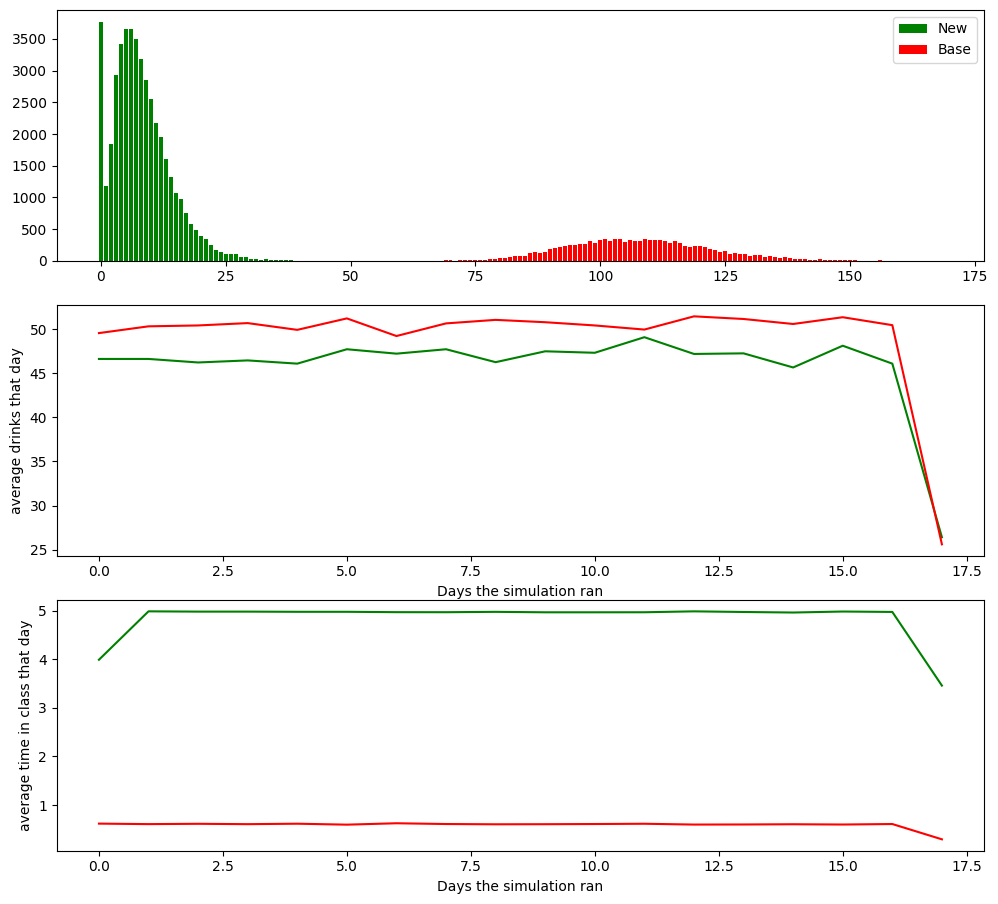

In [52]:
plot_comparison(sched_sorted_df, base_sorted_df)


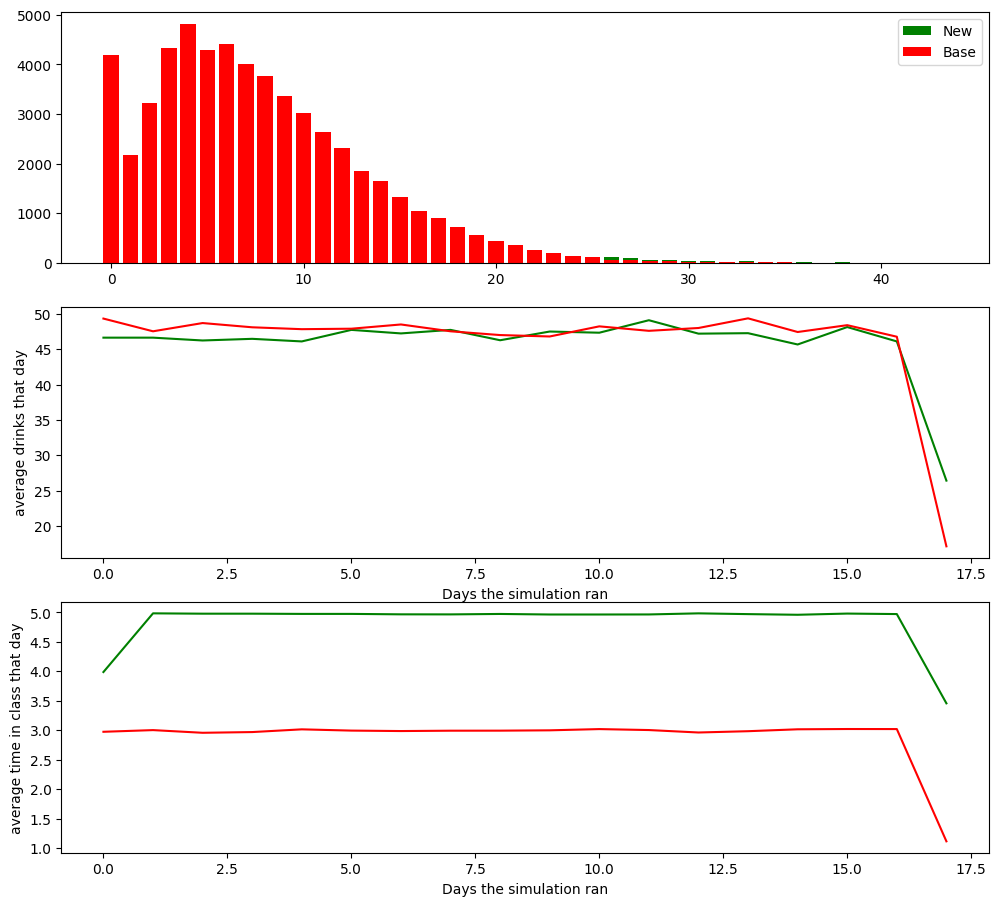

In [53]:
plot_comparison(sched_sorted_df, char_sorted_df)

## 4. Amount of Coffee machines

In [63]:
amount_df = pd.read_csv(os.path.join("..", batch_dir("batch_coff4"), "runs0", "data.csv"), index_col=False)

amount_df.head(10)

,ID,Timestamp,Name,Action,Duration,Day,Hour,Total Drinks,Time In Class
0,0,1,E,Co,0,0,0,0,0.0
1,1,1,N,Co,0,0,0,0,0.0
2,2,5,R,Co,4,0,0,0,0.0
3,3,5,d,Co,4,0,0,0,0.0
4,4,5,k,Co,0,0,0,0,0.0
5,5,6,q,Co,4,0,0,0,0.0
6,6,6,N,Co,4,0,0,0,0.0
7,7,6,i,Co,0,0,0,0,0.0
8,8,6,n,Co,3,0,0,0,0.0
9,9,7,L,Co,0,0,0,0,0.0


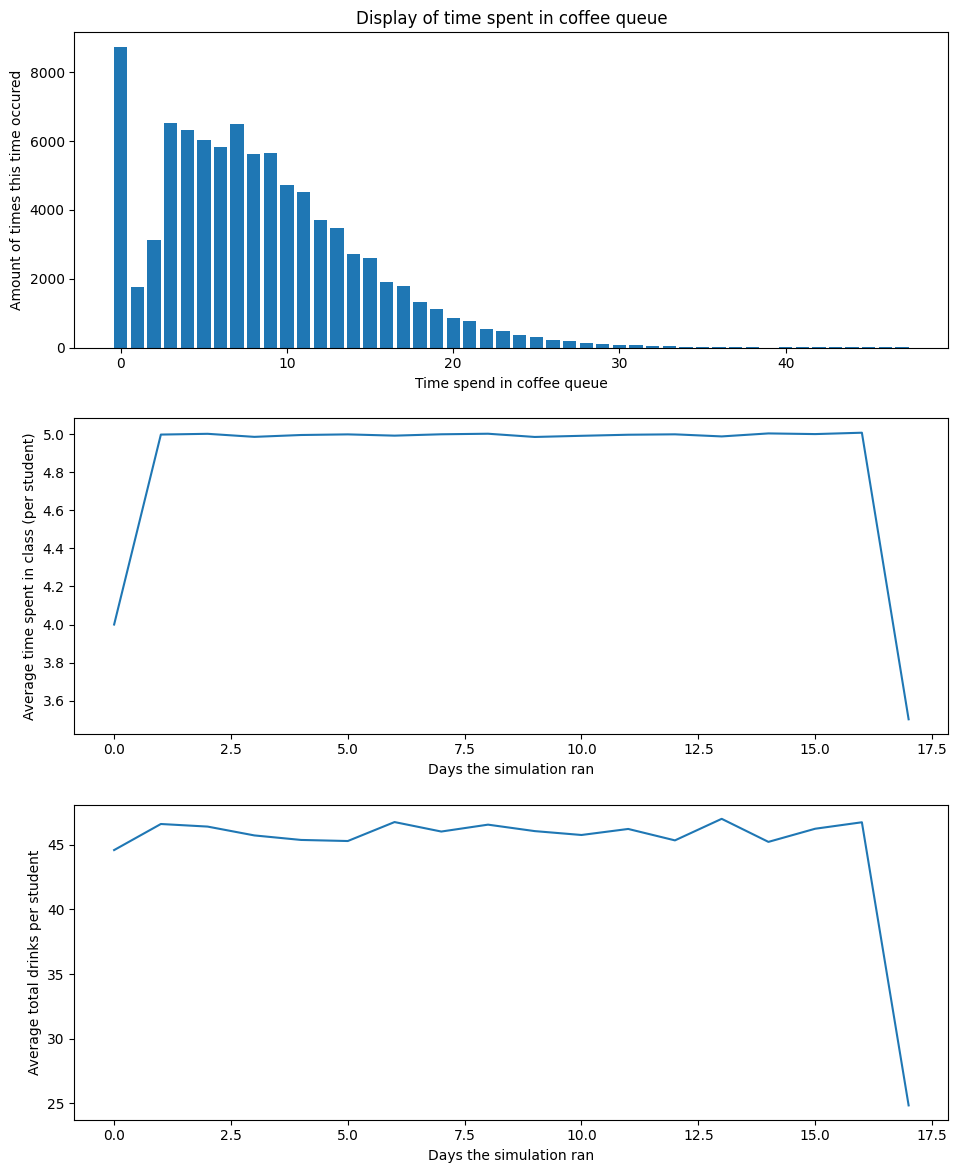

In [68]:
amount_sorted_df, amount_avg_total_drinks, amount_avg_time_in_class = plot_data(amount_df)

In [69]:
pd.DataFrame([
    ["Coffee machine (4)", np.round(amount_sorted_df["Duration"].mean()), np.round(amount_avg_total_drinks.mean()), np.round(amount_avg_time_in_class.mean(), 2)], 
    ["Schedule", np.round(sched_sorted_df["Duration"].mean()), np.round(sched_avg_total_drinks.mean()), np.round(sched_avg_time_in_class.mean(), 2)], 
    ["Characteristics", np.round(char_sorted_df["Duration"].mean()), np.round(char_avg_total_drinks.mean()), np.round(char_avg_time_in_class.mean(), 2)], 
    ["Base", np.round(base_sorted_df["Duration"].mean()), np.round(base_avg_total_drinks.mean()), np.round(base_avg_time_in_class.mean(), 2)]
], columns=["Name", "Duration in Queue (in timesteps)", "Average drinks per day per student", "Average hours spent in class per day"])

,Name,Duration in Queue (in timesteps),Average drinks per day per student,Average hours spent in class per day
0,Coffee machine (4),8.0,45.0,4.86
1,Schedule,8.0,46.0,4.83
2,Characteristics,8.0,46.0,2.89
3,Base,108.0,49.0,0.59
